We will simulate convergent beam electron diffraction (CBED) patterns for Dicalcium aluminium alumosilicate (http://www.crystallography.net/cod/1000048.html). This calculation ran in 22 seconds on my home 2 GB NVIDIA GTX 750 Ti and 5 min 22 seconds on my Intel i5 CPU.

In [1]:
import pyms
import numpy as np
import torch

# Get crystal
crystal = pyms.structure.fromfile('Structures/Au_001.xyz', atomic_coordinates = 'cartesian')

# Quick plot of crystal
# crystal.quickplot()

# Grid size in pixels
gridshape = [256,256]

# Tile out grid to acceptable size
tiling = [1,1]

# Probe accelerating voltage in eV
eV = 3e5

# Probe forming aperture in mrad
app = 0.000000000001

# Number of frozen phonon passes
nfph = 1

# Choose device to run calculation on (GPU or CPU)
# device = torch.device('cpu')
device = torch.device('cpu')

nslices = int(np.ceil(crystal.unitcell[2]/1))
slices = np.linspace(1.0/nslices,1.0,nslices)
slices[-1]=1.0

# Set up thickness series (up to a 1000 Angstrom in steps of 100 Angstrom)
tstep = 100
thicknesses = np.arange(tstep,1001,tstep)
thicknesses = crystal.unitcell[2]
print(thicknesses)
    
output = pyms.CBED(
    crystal,
    gridshape,
    eV,
    app,
    thicknesses = 408,
    subslices=slices,
    tiling=tiling,
    nfph=nfph,
    nT = 1,
    showProgress=False,
    device_type=device,
)



407.825


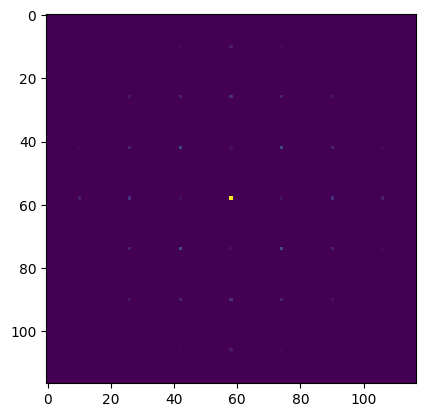

In [6]:
#Now plot results
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(output[0,:,:][27:144, 27:144]/np.sum(output[0,:,:][27:144, 27:144]), vmax = 0.05)

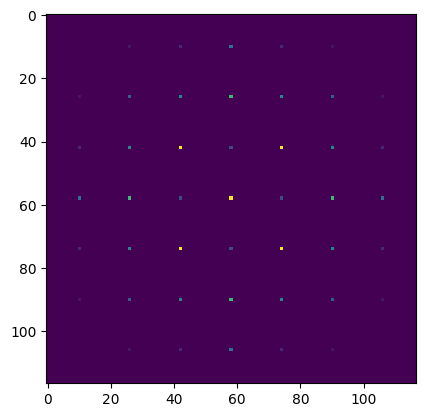

In [7]:
plt.imshow(output[0,:,:][27:144, 27:144]/np.sum(output[0,:,:][27:144, 27:144]), vmax = 0.01)